In [1]:
import contextlib
import io
import json
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
from pathlib import Path
from rdkit import Chem

from protein import Protein
%matplotlib inline

In [2]:
rc("font", size=18, weight="normal")

# Global variables

In [3]:
DATA_DIRECTORY = Path("data", "small_peptide_sampling_probability_distribution")
method = "random" # "random" or "adiabatic"
num_residues = 4
p = 62
num_visualized_configurations = 10

# Load data

In [4]:
num_residues_dir = Path(DATA_DIRECTORY, f"ala_{num_residues}_residues_clash_penalty=1000")
method_dir = Path(num_residues_dir, method)

In [5]:
probability_file = Path(method_dir, f"p={p}.json")
with probability_file.open("r") as f:
    probabilities_info = json.load(f)
energies, clashes, probabilities = np.array(probabilities_info["energies"]), np.array(probabilities_info["clashes"]), [np.array(probabilities_set) for probabilities_set in probabilities_info["probabilities"]]
min_energy = min(energies)
mds_file = Path(num_residues_dir, "mds.json")
with mds_file.open("r") as f:
    mds_info = json.load(f)
mds_pos, mds_sorted_confs_idx = np.array(mds_info["pos"]), mds_info["sorted_confs_idx"]

sorted_probabilities_idx = np.argsort(probabilities[0])[::-1]
probabilities_sorted_energies = energies[sorted_probabilities_idx]
probabilities_sorted_clashes = clashes[sorted_probabilities_idx]
probabilities_sorted_probabilities = probabilities[0][sorted_probabilities_idx]
probabilities_sorted_pdbs = np.array(probabilities_info["pdb"])[sorted_probabilities_idx]
q_values = np.cumsum(probabilities_sorted_probabilities)
random_guess_probability = [1 - (1 - (np.argmax(np.cumsum(probabilities_sorted_probabilities) >= q) + 1) / len(probabilities_sorted_probabilities)) ** p for q in q_values]

sorted_energies_idx = np.argsort(probabilities_info["energies"])
energy_sorted_energies = energies[sorted_energies_idx]
energy_sorted_clashes = clashes[sorted_energies_idx]
energy_sorted_probabilities = probabilities[0][sorted_energies_idx]
energy_sorted_pdbs = np.array(probabilities_info["pdb"])[sorted_energies_idx]

# Paper figures

## 3D views of conformations sorted according to different criteria

### Most frequent valid conformations sampled by QAOA

In [6]:
f = io.StringIO()
with contextlib.redirect_stderr(f):
    for idx, pdb in enumerate(probabilities_sorted_pdbs[:num_visualized_configurations]):
        try:
            protein = Protein(str(Path(num_residues_dir, pdb)))
            print(f"energy: {probabilities_sorted_energies[idx]} | probability {probabilities_sorted_probabilities[idx]}")
            print(pdb)
            Chem.Draw.IPythonConsole.drawMol3D(protein.mol)
            plt.show()
        except Exception as e:
            pass
            #print(f"error: {e}")

energy: 5.228455337533775 | probability 0.002336903392915532
13942_135441.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: 5.050810834419774 | probability 0.0021918911596624673
13941_135440.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: 5.03487031052153 | probability 0.002146276285173161
33625_397585.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: 13.434312676578715 | probability 0.002077155329174183
14032_135713.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: 13.27023940480062 | probability 0.00202879833551517
33715_397857.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: 4.8639745077975265 | probability 0.002010271160872472
33624_397584.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: 2.0034816280444585 | probability 0.0018897489836063495
13303_131617.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Most frequent invalid conformations sampled by QAOA

More precisely, for the sake of readability, we restrict to showing the most frequent conformations with _heavy_ atoms clashes; in other words, we skip the cases where only hydrogens clash.

In [7]:
f = io.StringIO()
with contextlib.redirect_stderr(f):
    non_h_invalid_conf_idx = 0
    for idx in np.argwhere(probabilities_sorted_clashes > 0).flatten():
        try:
            pdb = probabilities_sorted_pdbs[idx]
            protein = Protein(str(Path(num_residues_dir, pdb)))
            pos_dict = dict()
            for residue, atoms in protein.atoms_by_residue.items():
                for atom_name, atom in atoms.items():
                    pos = tuple(protein.conf.GetAtomPosition(atom.GetIdx()))
                    if pos not in pos_dict:
                        pos_dict[pos] = []
                    pos_dict[pos].append((residue, atom_name))
            clash_atoms = sum([pos_atoms for pos_atoms in pos_dict.values() if len(pos_atoms) > 1 and len([1 for pos_atom in pos_atoms if pos_atom[1].strip()[0] != "H"]) > 1], [])
            clash_atoms_set = set([pos_atom[1].strip()[0] for pos_atom in clash_atoms])
            if clash_atoms_set != {"H"} and clash_atoms_set != set():
                print(f"energy: {probabilities_sorted_energies[idx]} | probability {probabilities_sorted_probabilities[idx]}")
                print(pdb)
                Chem.Draw.IPythonConsole.drawMol3D(protein.mol)
                plt.show()
                non_h_invalid_conf_idx += 1
                if non_h_invalid_conf_idx >= num_visualized_configurations:
                    break
            else:
                #print("clashing atoms are H")
                pass
        except Exception as e:
            #print(f"error: {e}")
            pass

energy: 36469.606216115564 | probability 1.1537177447675322e-06
33172_394585.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: 13595.506743163636 | probability 7.279819181035896e-07
44434_559713.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: 36103.69771774727 | probability 3.2597468948954144e-07
24346_296033.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: 36087.80819975155 | probability 3.1548981091637644e-07
44029_558177.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: 36088.4679836809 | probability 3.073327864635958e-07
4663_33889.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: 39014.08064960086 | probability 2.889728325999941e-07
54022_663717.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: 29964.12773224402 | probability 2.584894514780155e-07
596_2370.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: 39014.149589182816 | probability 2.5457369008794783e-07
14656_139429.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: 39014.14714664524 | probability 2.458272454641907e-07
34339_401573.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: 89492.03505738334 | probability 1.9680791745099016e-07
38797_434601.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Energy-sorted conformations (lowest energy first)

These are independent of the optimization algorithm but simply represent the discretized conformational space.

In [8]:
f = io.StringIO()
with contextlib.redirect_stderr(f):
    for idx, pdb in enumerate(energy_sorted_pdbs[:num_visualized_configurations]):
        print(f"energy: {energy_sorted_energies[idx]} | probability {energy_sorted_probabilities[idx]}")
        print(pdb)
        try:
            protein = Protein(str(Path(num_residues_dir, pdb)))
            Chem.Draw.IPythonConsole.drawMol3D(protein.mol)
            plt.show()
        except Exception:
            print("error")

energy: -5.636349148395241 | probability 0.00012162569945811173
23805_288416.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: -5.5373012404859745 | probability 0.0001378712541705424
42948_547360.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: -5.491167348310563 | probability 0.00012158390100369586
4122_26272.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: -5.4257386308699465 | probability 9.108161230103015e-05
6319_43009.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: -5.351875709649306 | probability 0.00013883943466602055
23265_285216.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: -5.342156901061894 | probability 7.731992600477149e-05
3980_25874.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: -5.325799403265083 | probability 7.656313383893666e-05
23663_288018.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: -5.3247790894225115 | probability 5.5165184050294256e-05
42661_546177.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: -5.237281348763973 | probability 8.914058168865398e-05
45685_567297.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

energy: -5.166819025888952 | probability 5.003884989684016e-05
22978_284033.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Energy distribution of sampled conformations

The energy distribution is always conditioned on no clashes for readability (hence, the energy only includes the Lennard-Jones contribution and no clash penalization terms).

### For random sampling

Equivalently, $p = 0$ QAOA.

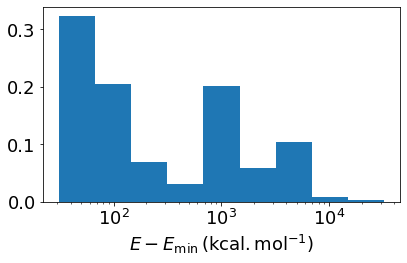

In [9]:
fig, ax = plt.subplots()
data = energies[clashes == 0] - (-36.68998911148465)
ax.hist(data, bins=np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), 10), weights=np.ones_like(data) / len(data))
ax.set_xscale("log")
ax.set_xlabel("$E - E_{\mathrm{min}}\,(\mathrm{kcal}.\mathrm{mol}^{-1})$")
fig.tight_layout()
fig.savefig(Path("figures", "small_peptide_sampling", f"energy_histogram_no_clashes_dimensionful_uniform__num_residues={num_residues}.eps"))

### For QAOA sampling

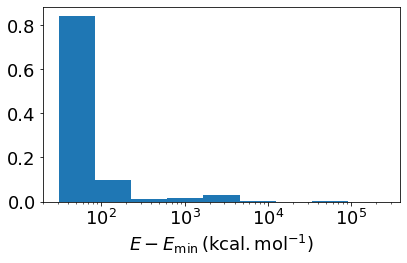

In [10]:
fig, ax = plt.subplots()
data = energies - (-36.68998911148465)
ax.hist(data, bins=np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), 10), weights=probabilities[0])
ax.set_xscale("log")
ax.set_xlabel("$E - E_{\mathrm{min}}\,(\mathrm{kcal}.\mathrm{mol}^{-1})$")
fig.tight_layout()
fig.savefig(Path("figures", "small_peptide_sampling", f"energy_histogram_dimensionful__method={method}__p={p}__num_residues={num_residues}.eps"))

## Multidimensional scaling representation of sampled conformational space

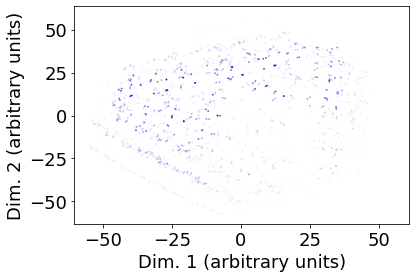

In [11]:
s = 3
colors = np.zeros((mds_pos.shape[0], 4))
colors[:, 0] = 0
colors[:, 1] = 0
colors[:, 2] = 0.8
max_proba = max(probabilities_info["probabilities"][0])
for idx, conf_idx in enumerate(mds_sorted_confs_idx):
    colors[idx, 3] = probabilities_info["probabilities"][0][conf_idx] / max_proba
fig, ax = plt.subplots()
ax.scatter(mds_pos[:, 0], mds_pos[:, 1], color=colors, s=s, lw=0, label="MDS")
ax.set_xlabel("Dim. 1 (arbitrary units)")
ax.set_ylabel("Dim. 2 (arbitrary units)")
fig.savefig(Path("figures", "small_peptide_sampling", f"mds__method={method}__p={p}__num_residues={num_residues}.png"), bbox_inches="tight")

## Comparing QAOA and random sampling

Note that in the segment of code, contrary to the previous ones, we iterated over ansatz levels $p$ given the number of residues and the parameter optimization method. Therefore, there is no need to reexecute this bit of code when changing $p$ in the parameters at the top of the noteboook.

p = 2
p = 3
p = 8
p = 62


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


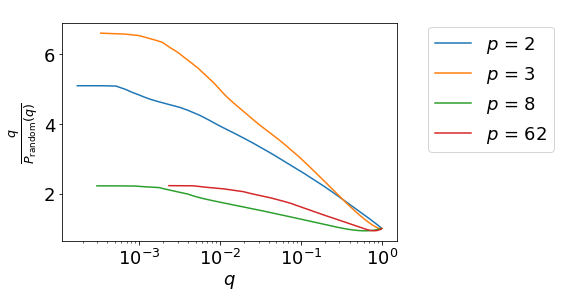

In [12]:
fig, ax = plt.subplots()
probability_files = list(Path(method_dir).glob("p=*.json"))
for tmp_probability_file in probability_files:
    tmp_p = int(tmp_probability_file.stem.split("=")[1])
    print(f"p = {tmp_p}")
    with tmp_probability_file.open("r") as f:
        tmp_probabilities_info = json.load(f)
    tmp_energies, tmp_clashes, tmp_probabilities = np.array(tmp_probabilities_info["energies"]), np.array(tmp_probabilities_info["clashes"]), [np.array(probabilities_set) for probabilities_set in tmp_probabilities_info["probabilities"]]
    tmp_sorted_probabilities_idx = np.argsort(tmp_probabilities[0])[::-1]
    tmp_probabilities_sorted_energies = np.array(tmp_probabilities_info["energies"])[tmp_sorted_probabilities_idx]
    tmp_probabilities_sorted_probabilities = tmp_probabilities[0][tmp_sorted_probabilities_idx]
    tmp_probabilities_sorted_pdbs = np.array(tmp_probabilities_info["pdb"])[tmp_sorted_probabilities_idx]
    tmp_q_values = np.cumsum(tmp_probabilities_sorted_probabilities)
    tmp_random_guess_probability = [1 - (1 - (np.argmax(np.cumsum(tmp_probabilities_sorted_probabilities) >= q) + 1) / len(tmp_probabilities_sorted_probabilities)) ** tmp_p for q in tmp_q_values]
    ax.semilogx(tmp_q_values, tmp_q_values / tmp_random_guess_probability, "-", ms=1, label=f"$p$ = {tmp_p}")
ax.set_xlabel("$q$")
ax.set_ylabel("$\\frac{q}{P_{\mathrm{random}}(q)}$")
fig.legend(loc="upper left", bbox_to_anchor=(0.97, 0.97))
fig.savefig(Path("figures", "small_peptide_sampling", f"qaoa_vs_uniform_probability__method={method}__all_p__num_residues={num_residues}.eps"), bbox_inches="tight")